<a href="https://colab.research.google.com/github/zinm/Android/blob/master/80%25%2B%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import os
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from keras.models import load_model

from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from keras.preprocessing import image
from os import listdir
from os.path import isfile, join
import re
import matplotlib.image as mpimg

In [21]:
from keras.applications import VGG16

# VGG16 was designed to work on 224 x 224 pixel input images sizes
img_rows = 32
img_cols = 32

# Re-loads the VGG16 model without the top or FC layers
vgg16 = VGG16(weights = 'imagenet', include_top = False,  input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers, layers are set to trainable as True by default
for layer in vgg16.layers:
    layer.trainable = False

for (i,layer) in enumerate(vgg16.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [22]:
train_data_dir = '/content/drive/MyDrive/datset/processed_data/train'
validation_data_dir = '/content/drive/MyDrive/datset/processed_data/val'

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
train_batchsize = 64
val_batchsize = 64
 
train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_rows, img_cols),
                                                    batch_size=train_batchsize, class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(validation_data_dir, target_size=(img_rows, img_cols),
                                                              batch_size=val_batchsize, class_mode='categorical', shuffle=False)

Found 2890 images belonging to 20 classes.
Found 958 images belonging to 20 classes.


In [23]:
def addTopModel(bottom_model, num_classes, D=256):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""
    top_model = bottom_model.output
    top_model = Flatten(name = "flatten")(top_model)
    top_model = Dense(D, activation = "relu")(top_model)
    top_model = Dropout(0.3)(top_model)
    top_model = Dense(num_classes, activation = "softmax")(top_model)
    return top_model

In [24]:
from keras.layers.normalization import BatchNormalization
from keras.models import Model

num_classes = 20

FC_Head = addTopModel(vgg16, num_classes)

model = Model(inputs=vgg16.input, outputs=FC_Head)

model.summary()


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [25]:
checkpoint = ModelCheckpoint("trained_model/aksara.h5", monitor="val_loss", mode="min", save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss',  min_delta = 0,  patience = 3, verbose = 1, restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

callbacks = [checkpoint, reduce_lr]

model.compile(loss = 'categorical_crossentropy', optimizer = RMSprop(lr = 0.001), metrics = ['accuracy'])

nb_train_samples = 2890
nb_validation_samples = 958
epochs = 25
batch_size = 64

history = model.fit_generator(train_generator, steps_per_epoch = nb_train_samples // batch_size, epochs = epochs, 
                              callbacks = callbacks, validation_data = validation_generator,
                              validation_steps = nb_validation_samples // batch_size)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
45/45 [==============================] - 7s 137ms/step - loss: 2.5288 - accuracy: 0.2233 - val_loss: 1.5860 - val_accuracy: 0.5882

Epoch 00001: val_loss improved from inf to 1.58598, saving model to trained_model/aksara.h5
Epoch 2/25
45/45 [==============================] - 6s 129ms/step - loss: 1.7709 - accuracy: 0.4451 - val_loss: 1.1851 - val_accuracy: 0.6719

Epoch 00002: val_loss improved from 1.58598 to 1.18506, saving model to trained_model/aksara.h5
Epoch 3/25
45/45 [==============================] - 6s 130ms/step - loss: 1.4201 - accuracy: 0.5538 - val_loss: 1.0188 - val_accuracy: 0.7031

Epoch 00003: val_loss improved from 1.18506 to 1.01882, saving model to trained_model/aksara.h5
Epoch 4/25
45/45 [==============================] - 6s 130ms/step - loss: 1.3053 - accuracy: 0.5745 - val_loss: 0.8876 - val_accuracy: 0.7377

Epoch 00004: val_loss improved from 1.01882 to 0.88757, saving model to trained_model/aksara.h5
Epoch 5/25
45/45 [==============================

In [26]:
m = load_model('trained_model/aksara.h5')

In [27]:
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())
print(class_labels)

{0: 'a', 1: 'ba', 2: 'ca', 3: 'da', 4: 'ga', 5: 'gha', 6: 'ha', 7: 'ja', 8: 'ka', 9: 'la', 10: 'ma', 11: 'na', 12: 'nga', 13: 'nya', 14: 'pa', 15: 'ra', 16: 'sa', 17: 'ta', 18: 'wa', 19: 'ya'}



( 1 )


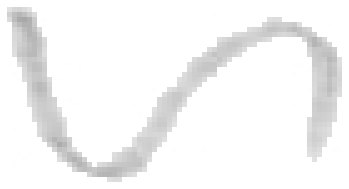

Predicted:  ha
True:  ha

( 2 )


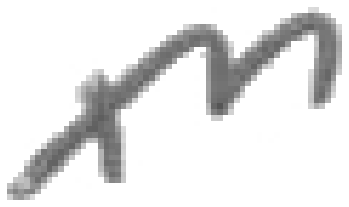

Predicted:  ja
True:  ja

( 3 )


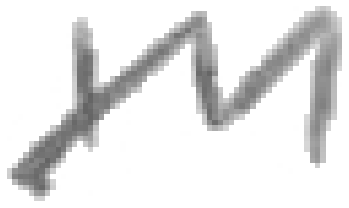

Predicted:  ja
True:  ja

( 4 )


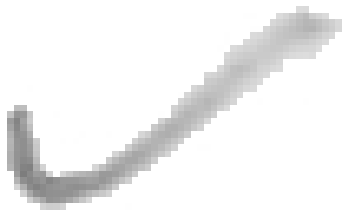

Predicted:  pa
True:  pa

( 5 )


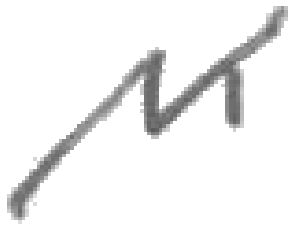

Predicted:  nga
True:  nga


In [28]:
# checking model on validation data
def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our validation path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size = (img_width, img_height)), final_path, path_class

# dimensions of our images
img_width, img_height = 32, 32

files = []
predictions = []
true_labels = []

# predicting images
for i in range(0, 5):
    path = '/content/drive/MyDrive/datset/processed_data/val/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = np.argmax(m.predict(images, batch_size = 10))
    predictions.append(classes)
    
for i in range(0, len(files)):
    img=mpimg.imread((files[i]))
    print("\n(",i+1,")")
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print("Predicted: ",class_labels[predictions[i]])
    print("True: ",true_labels[i])

In [30]:
def check_1(path):
    img=mpimg.imread(path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    # prediction
    img = image.load_img(path, target_size=(32, 32))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x.astype('float32')/255
    pred = np.argmax(m.predict(x))
    print("It's a {}.".format(class_labels[pred]))

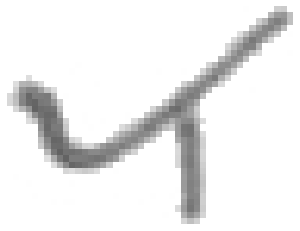

It's a la.


In [33]:
check_1("/content/drive/MyDrive/test/ba/ba 000.jpeg")

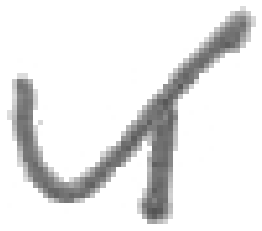

It's a ba.


In [34]:
check_1("/content/drive/MyDrive/test/ba/ba 003.jpeg")

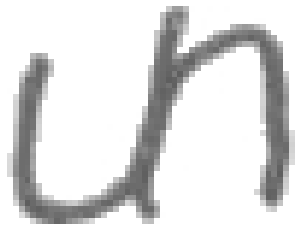

It's a ca.


In [36]:
check_1("/content/drive/MyDrive/test/ca/ca 010.jpeg")

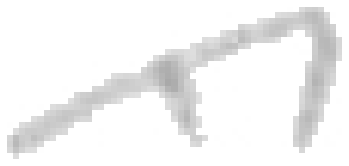

It's a ka.


In [37]:
check_1("/content/drive/MyDrive/test/ka/ka 014.jpeg")